In [1]:
!pip install torchsummary

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchsummary as summary
import time
import torch
from torch import nn
import torchvision
from torchvision import models,transforms
from torch.utils.data import DataLoader,Dataset
import os
from PIL import Image

In [3]:
!nvidia-smi

Tue Sep  7 11:08:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
class_dict=pd.read_csv("../input/100-bird-species/birds_rev2/class_dict.csv")
class_dict

,class_index,class,height,width,scale by
0,0.0,AFRICAN CROWNED CRANE,224,224,1
1,1.0,AFRICAN FIREFINCH,224,224,1
2,2.0,ALBATROSS,224,224,1
3,3.0,ALEXANDRINE PARAKEET,224,224,1
4,4.0,AMERICAN AVOCET,224,224,1
...,...,...,...,...,...
812,NaN,NaN,224,224,1
813,NaN,NaN,224,224,1
814,NaN,NaN,224,224,1
815,NaN,NaN,224,224,1


In [6]:
bird_data=pd.read_csv("../input/100-bird-species/birds_rev2/birds.csv")
bird_data

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train
...,...,...,...
42109,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid
42110,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid
42111,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid
42112,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid


In [7]:
train_path=os.listdir("../input/100-bird-species/birds_rev2/train")
val_path=os.listdir("../input/100-bird-species/birds_rev2/valid")
test_path=os.listdir("../input/100-bird-species/birds_rev2/test")

In [8]:
a=class_dict['class'].unique()[:-1]
name_dict=dict(zip(a,np.arange(275)))


In [9]:
bird_data['data set'].unique()

array(['train', 'test', 'valid'], dtype=object)

In [10]:
train_pd=bird_data[bird_data['data set']=='train']
train_pd

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train
...,...,...,...
39359,train/YELLOW HEADED BLACKBIRD/155.jpg,YELLOW HEADED BLACKBIRD,train
39360,train/YELLOW HEADED BLACKBIRD/156.jpg,YELLOW HEADED BLACKBIRD,train
39361,train/YELLOW HEADED BLACKBIRD/157.jpg,YELLOW HEADED BLACKBIRD,train
39362,train/YELLOW HEADED BLACKBIRD/158.jpg,YELLOW HEADED BLACKBIRD,train


In [11]:
val_pd=pd.DataFrame(bird_data[bird_data['data set']=='valid'].values,columns=['filepaths','labels','data set'])
val_pd

,filepaths,labels,data set
0,valid/AFRICAN CROWNED CRANE/1.jpg,AFRICAN CROWNED CRANE,valid
1,valid/AFRICAN CROWNED CRANE/2.jpg,AFRICAN CROWNED CRANE,valid
2,valid/AFRICAN CROWNED CRANE/3.jpg,AFRICAN CROWNED CRANE,valid
3,valid/AFRICAN CROWNED CRANE/4.jpg,AFRICAN CROWNED CRANE,valid
4,valid/AFRICAN CROWNED CRANE/5.jpg,AFRICAN CROWNED CRANE,valid
...,...,...,...
1370,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid
1371,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid
1372,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid
1373,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid


In [12]:
test_pd=pd.DataFrame(bird_data[bird_data['data set']=='test'].values,columns=['filepaths','labels','data set'])
test_pd

,filepaths,labels,data set
0,test/AFRICAN CROWNED CRANE/1.jpg,AFRICAN CROWNED CRANE,test
1,test/AFRICAN CROWNED CRANE/2.jpg,AFRICAN CROWNED CRANE,test
2,test/AFRICAN CROWNED CRANE/3.jpg,AFRICAN CROWNED CRANE,test
3,test/AFRICAN CROWNED CRANE/4.jpg,AFRICAN CROWNED CRANE,test
4,test/AFRICAN CROWNED CRANE/5.jpg,AFRICAN CROWNED CRANE,test
...,...,...,...
1370,test/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,test
1371,test/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,test
1372,test/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,test
1373,test/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,test


#计算整个数据集图片的均值和方差
from imageio import imread

filepath = '../input/100-bird-species/birds_rev2'  # 数据集目录

pathDir = train_pd['filepaths']

R_channel = 0
G_channel = 0
B_channel = 0
for idx in range(len(pathDir)):
    filename = pathDir[idx]
    img = imread(os.path.join(filepath, filename))/255.0
    R_channel = R_channel + np.sum(img[:, :, 0])
    G_channel = G_channel + np.sum(img[:, :, 1])
    B_channel = B_channel + np.sum(img[:, :, 2])
 
num = len(pathDir) * 224*224  # 这里（1024,1024）是每幅图片的大小，所有图片尺寸都一样
R_mean = R_channel / num  # or /255.0
G_mean = G_channel / num 
B_mean = B_channel / num 
 
R_channel = 0
G_channel = 0
B_channel = 0
for idx in range(len(pathDir)):
    filename = pathDir[idx]
    img = imread(os.path.join(filepath, filename))/255.0
    R_channel = R_channel + np.sum((img[:, :, 0] - R_mean) ** 2)
    G_channel = G_channel + np.sum((img[:, :, 1] - G_mean) ** 2)
    B_channel = B_channel + np.sum((img[:, :, 2] - B_mean) ** 2)
 
R_var = np.sqrt(R_channel / num)
G_var = np.sqrt(G_channel / num)
B_var = np.sqrt(B_channel / num)
print("R_mean is %f, G_mean is %f, B_mean is %f" % (R_mean, G_mean, B_mean))
print("R_var is %f, G_var is %f, B_var is %f" % (R_var, G_var, B_var))
# R_mean is 0.469289, G_mean is 0.467588, B_mean is 0.393907
# R_var is 0.238269, G_var is 0.232191, B_var is 0.254105

In [13]:
class birddataset(Dataset):
    def __init__(self,in_pd,name_dict,transform):
        self.inpd=in_pd
        self.name_dict=name_dict
        self.transform=transform
    def __len__(self):
        return len(self.inpd)
    def __getitem__(self,idx):
        img=Image.open(os.path.join("../input/100-bird-species/birds_rev2",self.inpd['filepaths'][idx]))
        label=torch.tensor(name_dict[self.inpd['labels'][idx]]).to(device)
        img=transform(img).to(device)
        return img,label

In [14]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.469289, 0.467588, 0.393907), (0.238269, 0.232191, 0.254105))])

In [15]:
train_dataset=birddataset(train_pd,name_dict,transform)
val_dataset=birddataset(val_pd,name_dict,transform)
test_dataset=birddataset(test_pd,name_dict,transform)


In [16]:
batchsize=128

In [17]:
train_dataloader=DataLoader(train_dataset,batchsize,shuffle=True)
val_dataloader=DataLoader(val_dataset,batchsize,shuffle=True)
test_dataloader=DataLoader(test_dataset,batchsize,shuffle=True)

In [18]:
class alexnet(nn.Module):
    def __init__(self):
        super(alexnet,self).__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),
            #nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.conv2=nn.Sequential(
            nn.Conv2d(64,192,kernel_size=5,padding=2),
            #nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.conv3=nn.Sequential(
            nn.Conv2d(192,384,kernel_size=3,padding=1),
            #nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
        )
        self.conv4=nn.Sequential(
            nn.Conv2d(384,256,kernel_size=3,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.conv5=nn.Sequential(
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            #nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),
            nn.AdaptiveAvgPool2d((6,6))
        )
        self.conv6=nn.Sequential(
            nn.Flatten(),
            nn.Dropout(),
            nn.Linear(6*6*256,4096),
            nn.ReLU(),
            nn.Dropout()
        )
        self.conv7=nn.Sequential(
            nn.Linear(4096,4096),
            nn.ReLU()
        )
        self.conv8=nn.Sequential(
            nn.Linear(4096,275)
        )
        #self.softmax=nn.Softmax(dim=1)
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        x=self.conv6(x)
        x=self.conv7(x)
        x=self.conv8(x)
        #x=self.softmax(x)
        return x

In [19]:
alexnet1=alexnet()
alexnet1=alexnet1.to(device)
alexnet1

alexnet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (conv6): Sequential(
    (0): Fl

In [20]:
summary.summary(alexnet1,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [21]:
alexnet_pro=torchvision.models.alexnet(pretrained=True,progress=True).to(device)
summary.summary(alexnet_pro,(3,224,224))

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [22]:
optim=torch.optim.SGD(alexnet1.parameters(),0.01)
loss=torch.nn.CrossEntropyLoss().to(device)

In [23]:
epoc=40

In [24]:
train_cost_array=np.zeros(epoc*2)
train_acc_array=np.zeros(epoc*2)
val_cost_array=np.zeros(epoc*2)
val_acc_array=np.zeros(epoc*2)
for i in range(epoc):
    train_cost=0
    train_acc=0
    val_cost=0
    val_acc=0
    step=0
    train_start=time.time()
    alexnet1.train()
    for img,lab in train_dataloader:
        img=img.to(device)
        lab=lab.to(device)
        optim.zero_grad()
        y_hat=alexnet1(img)
        res_loss=loss(y_hat,lab)
        train_cost=train_cost+res_loss*len(lab)
        train_acc=train_acc+(y_hat.argmax(1)==lab).sum()
        step=step+1
        res_loss.backward()
        optim.step()
        if step%100==0:
            print(f"epoc: {i},step: {step},cost: {res_loss},acc count: {train_acc},acc: {train_acc/39364}\n")
    train_acc_array[i]=train_acc.item()/39364
    train_cost_array[i]=train_cost.item()/39364
    train_end=time.time()
    print('-'*100+'\n')
    print(f"epoc: {i},cost: {train_cost},acc count: {train_acc},acc: {train_acc/39364},time: {train_end-train_start}\n")
    alexnet1.eval()
    with torch.no_grad():
        
        val_start=time.time()
        for img,lab in val_dataloader:
            img=img.to(device)
            lab=lab.to(device)
            y_hat=alexnet1(img)
            res_loss=loss(y_hat,lab)
            val_cost=val_cost+res_loss*len(lab)
            val_acc=val_acc+(y_hat.argmax(1)==lab).sum()
        val_acc_array[i]=val_acc.item()/1375
        val_cost_array[i]=val_cost.item()/1375
        val_end=time.time()
        print(f"epoc: {i},cost: {val_cost},acc count: {val_acc},acc: {val_acc/1375},time: {val_end-val_start}\n")
        print('-'*100+'\n')

epoc: 0,step: 100,cost: 5.616885662078857,acc count: 46,acc: 0.0011685803765431046

epoc: 0,step: 200,cost: 5.616650104522705,acc count: 89,acc: 0.002260948996990919

epoc: 0,step: 300,cost: 5.616755485534668,acc count: 163,acc: 0.004140839446336031

----------------------------------------------------------------------------------------------------

epoc: 0,cost: 221089.8125,acc count: 169,acc: 0.004293262958526611,time: 305.2503356933594

epoc: 0,cost: 7723.0,acc count: 5,acc: 0.0036363634280860424,time: 10.078961610794067

----------------------------------------------------------------------------------------------------

epoc: 1,step: 100,cost: 5.614164352416992,acc count: 89,acc: 0.002260948996990919

epoc: 1,step: 200,cost: 5.618387222290039,acc count: 177,acc: 0.004496494308114052

epoc: 1,step: 300,cost: 5.614666938781738,acc count: 251,acc: 0.006376384291797876

----------------------------------------------------------------------------------------------------

epoc: 1,cost:

In [25]:
optim=torch.optim.SGD(alexnet1.parameters(),0.001)

In [26]:
for i in range(epoc):
    train_cost=0
    train_acc=0
    val_cost=0
    val_acc=0
    step=0
    train_start=time.time()
    alexnet1.train()
    for img,lab in train_dataloader:
        img=img.to(device)
        lab=lab.to(device)
        optim.zero_grad()
        y_hat=alexnet1(img)
        res_loss=loss(y_hat,lab)
        train_cost=train_cost+res_loss*len(lab)
        train_acc=train_acc+(y_hat.argmax(1)==lab).sum()
        step=step+1
        res_loss.backward()
        optim.step()
        if step%100==0:
            print(f"epoc: {epoc+i},step: {step},cost: {res_loss},acc count: {train_acc},acc: {train_acc/39364}\n")
    train_acc_array[epoc+i]=train_acc.item()/39364
    train_cost_array[epoc+i]=train_cost.item()/39364
    train_end=time.time()
    print('-'*100+'\n')
    print(f"epoc: {epoc+i},cost: {train_cost},acc count: {train_acc},acc: {train_acc/39364},time: {train_end-train_start}\n")
    alexnet1.eval()
    with torch.no_grad():
        val_start=time.time()
        for img,lab in val_dataloader:
            img=img.to(device)
            lab=lab.to(device)
            y_hat=alexnet1(img)
            res_loss=loss(y_hat,lab)
            val_cost=val_cost+res_loss*len(lab)
            val_acc=val_acc+(y_hat.argmax(1)==lab).sum()
        val_acc_array[epoc+i]=val_acc.item()/1375
        val_cost_array[epoc+i]=val_cost.item()/1375
        val_end=time.time()
        print(f"epoc: {epoc+i},cost: {val_cost},acc count: {val_acc},acc: {val_acc/1375},time: {val_end-val_start}\n")
        print('-'*100+'\n')

epoc: 40,step: 100,cost: 0.5910715460777283,acc count: 10440,acc: 0.2652169466018677

epoc: 40,step: 200,cost: 0.46992915868759155,acc count: 21061,acc: 0.5350320339202881

epoc: 40,step: 300,cost: 0.6237081289291382,acc count: 31739,acc: 0.8062950968742371

----------------------------------------------------------------------------------------------------

epoc: 40,cost: 24059.888671875,acc count: 32539,acc: 0.8266182541847229,time: 130.2194311618805

epoc: 40,cost: 1331.016357421875,acc count: 1045,acc: 0.7599999904632568,time: 3.8536972999572754

----------------------------------------------------------------------------------------------------

epoc: 41,step: 100,cost: 0.4640265107154846,acc count: 10836,acc: 0.27527689933776855

epoc: 41,step: 200,cost: 0.5408029556274414,acc count: 21615,acc: 0.5491057634353638

epoc: 41,step: 300,cost: 0.5071084499359131,acc count: 32361,acc: 0.8220963478088379

----------------------------------------------------------------------------------

In [27]:
test_cost=0
test_acc=0
alexnet1.eval()
with torch.no_grad():
    val_start=time.time()
    for img,lab in val_dataloader:
        img=img.to(device)
        lab=lab.to(device)
        y_hat=alexnet1(img)
        res_loss=loss(y_hat,lab)
        test_cost=test_cost+res_loss*len(lab)
        test_acc=test_acc+(y_hat.argmax(1)==lab).sum()
    val_end=time.time()
    print(f"test cost: {test_cost},acc count: {test_acc},acc: {test_acc/1375},time: {val_end-val_start}\n")
    

test cost: 1453.10546875,acc count: 1063,acc: 0.7730908989906311,time: 3.6747236251831055



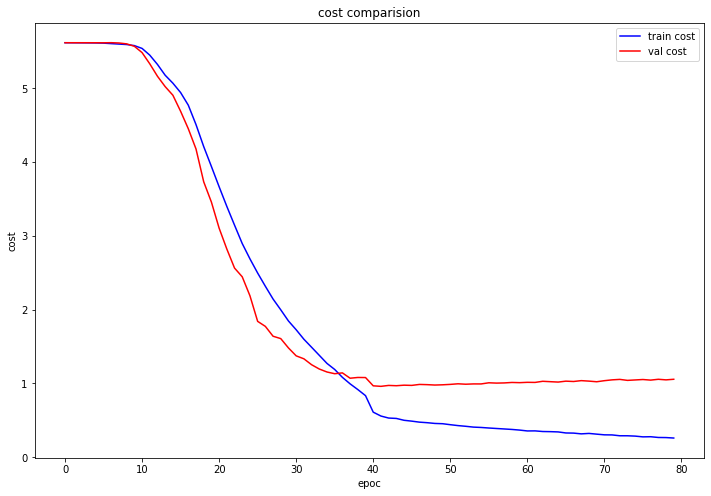

In [28]:
plt.figure(figsize=(12,8))

plt.plot(np.arange(epoc*2),train_cost_array,c='b',label='train cost')
plt.plot(np.arange(epoc*2),val_cost_array,c='r',label='val cost')
plt.xlabel('epoc')
plt.ylabel('cost')
plt.title('cost comparision')
plt.legend()



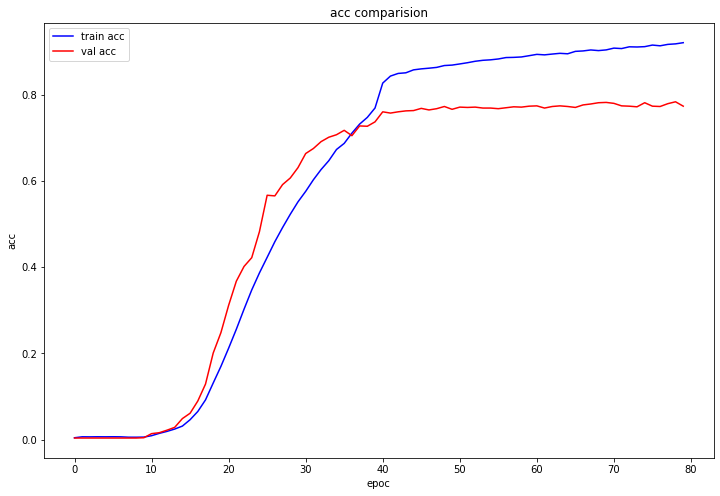

In [29]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(epoc*2),train_acc_array,c='b',label='train acc')
plt.plot(np.arange(epoc*2),val_acc_array,c='r',label='val acc')
plt.xlabel('epoc')
plt.ylabel('acc')
plt.title('acc comparision')
plt.legend()

In [30]:
torch.save(alexnet1.state_dict(),'alexnet_para.pth')

In [31]:
alexnet_mod=alexnet()
alexnet_mod.load_state_dict(torch.load('alexnet_para.pth'))

<All keys matched successfully>